In [5]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel
from typing import List
import os
from dotenv import load_dotenv

load_dotenv(dotenv_path="../../.env")

llm = init_chat_model("ollama:gpt-oss:120b", base_url=os.environ.get("OLLAMA_BASE_URL"))


class State(TypedDict):
    dish: str
    ingredients: list[dict]
    recipe_steps: str
    plating_instructions: str


class Ingredient(BaseModel):
    name: str
    quantity: str
    unit: str


class IngredientsOutput(BaseModel):
    ingredients: List[Ingredient]

In [6]:
def list_ingredients(state: State):
    structured_llm = llm.with_structured_output(IngredientsOutput)
    response = structured_llm.invoke(
        f"List 5-8 ingredients needed to make {state["dish"]}"
    )

    return {"ingredients": response.ingredients}


def create_recipe(state: State):
    response = llm.invoke(
        f"Write a step by step cooking instruction for {state["dish"]} using these ingredients {state["ingredients"]}"
    )

    return {
        "recipe_steps": response.content,
    }


def describe_plating(state: State):
    response = llm.invoke(
        f"Describe how to beautifully plate this {state["dish"]} based on this recipe {state["recipe_steps"]}"
    )

    return {
        "plating_instructions": response.content,
    }


def gate(state: State):
    ingredients = state["ingredients"]
    if len(ingredients) > 8 or len(ingredients) < 3:
        return False

    return True

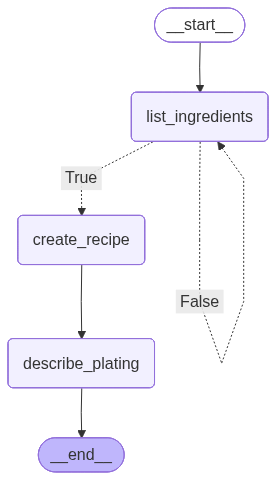

In [7]:
graph_builder = StateGraph(State)

graph_builder.add_node("list_ingredients", list_ingredients)
graph_builder.add_node("create_recipe", create_recipe)
graph_builder.add_node("describe_plating", describe_plating)

graph_builder.add_edge(START, "list_ingredients")
graph_builder.add_conditional_edges(
    "list_ingredients",
    gate,
    {
        True: "create_recipe",
        False: "list_ingredients",
    },
)
graph_builder.add_edge("create_recipe", "describe_plating")
graph_builder.add_edge("describe_plating", END)


graph = graph_builder.compile()

graph
# graph.invoke({"dish": "hummus"})